# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
from pandas import Series, DataFrame

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Import Data

Warning: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

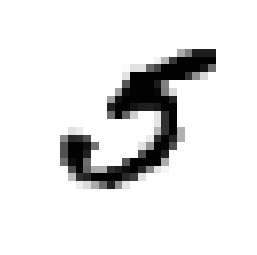

In [7]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

### Create Test Set

In [8]:
# label confirms it's a 5
y[36000]

5

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# MNIST dataset is already split into a training set (the frist 60,000 images) and a test set (the last 10,000 images)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
# Shuffling the traiing set will guarantee that all cross-validation folds will be similar
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [12]:
# Let's simplify the problem for now and only try to identify one digit - for example the number 5.
# This "5-detector" will be an example of a binary classifier, capable of distinguishing between just two classes
# 5 and not-5. Let's create the target vectors for this classification task:

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) # True for all 5s, False for all other digits

In [14]:
# Good place to start is with a Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
# Use to detect an image of the number 5, and it guessed right. Recall, some_digit was defined earlier
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

### Measuring Accuracy Using Cross-Validation

In [16]:
# Let's use the corss_val_score() function to evalute the SGDClassifier model using K-fold cross-validation (3 folds)
# RESULTS show over 95% accuracy on each of the three folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [17]:
# BUT, let's look at a dumb classifier that just classifies every single image in the "not-5" class:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
# RESULTS show over 90% accuracy. This is simply because only about 10% of the images are 5s, so if you always guess
# that an image is not a 5, you will be right about 90% of the time!
# This deomonstrates why ACCURACY is generally not the preferred performance measure for classifiers, especially when
# you are dealing with skewed datasets
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

### Confusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
# Each row in a confusion matrix represents an actual class, while each column represents a predicted class
# In this example, the first row consisders non-5s, 53,272 were correctly classified as non-5s (true negatives)
# While the remaining 1,307 were wrongly classified as 5s (false positives)
# The second row considers the images of 5s, 1,077 were wrongly classified as non-5s (false negatives),
# While the remaining 4,344 were correctly classified as 5s (true positives)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

TP = true positives; FP = false positives; FN = false negatives

Precision  = TP / (TP + FP)
"Ratio of true positives (TP) amongst the real values"

Recall = TP / (TP + FN)
"Ratio of true positives (TP) amonst the predicted values"

### Precision and Recall

In [21]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4344 / (4344 + 1307)

0.7687135020350381

In [22]:
recall_score(y_train_5, y_train_pred) # 4344 / (4344 + 1077)

0.801328168234643

In [23]:
# F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the
# harmonic mean gives much more weight to low values. As a result, the clasifier will only get a high F1 score if
# both recall and precision are high
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [25]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

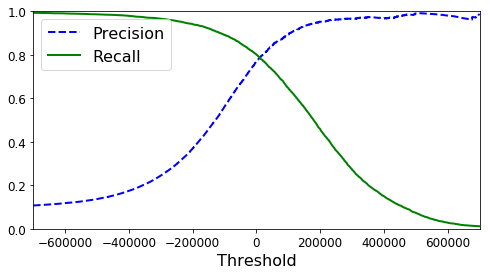

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

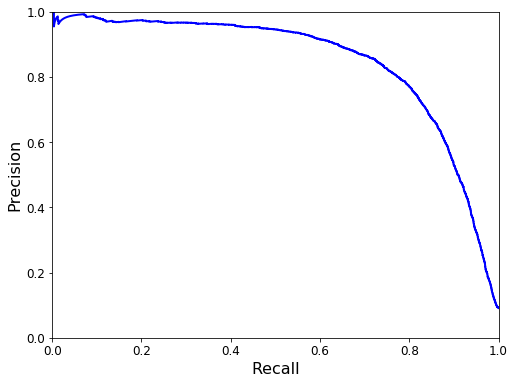

In [28]:
# One way to select a good precision/recall tradeoff is to plot precision directly against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### The ROC Curve

In [29]:
# The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers
# THE ROC curve plots the true positive rate (recall) against the false positive rate
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

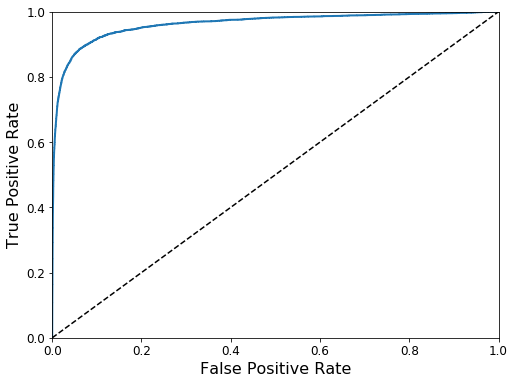

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

Dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (towards the top-left corner)

In [31]:
# One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a 
# ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

You should prefer the precision/recall (or PR) curve whenever the positiive class is rare OR when you care more about false positiives than the false negatives, and the ROC curve otherwise. 

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifer is really good. But this is because there are a few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve should be closer to the top right corner).

In [32]:
# Note: we set n_estimators=10 to avoid a warning about the fact that 
# its default value will be set to 100 in Scikit-Learn 0.22.
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

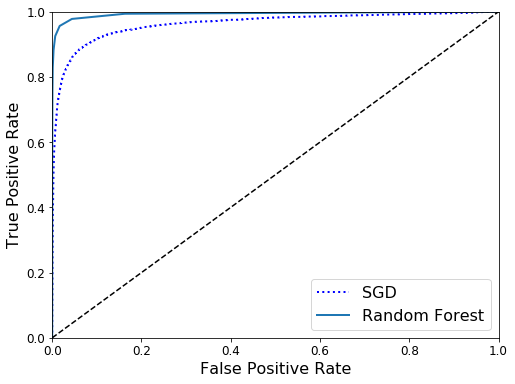

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()
# Notice it's much closer to the top-left corner, and as a result the AUC is much better

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [36]:
# Better precision and recall scores as well
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [37]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass Classification

Some algorithms (such as Random Forest clssifiers or naive Bayes classifiers) are capable of handling multiple classes directly.

Others (such as Support Vector Machines classifiers or Linear classifiers) are strictly binary classifiers. 

OvA Strategy (One-Versus-All): Train n binary classifiers to cover the set, and then pick the highest score

OvO Strategy (One-versus-One): Train a binary classifier for each pair to cover the set. So if N classes, need to train N x N (N-1) / 2 classifiers. Then you see which class wins the most duels.

For most binary classification algorithms, OvA is the preferred method. Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, and so OvO is preferred.

In [38]:
# Scikit-learn detects when you try to use a binary classification algorithm for a multiclass clssificatio task,
# and it automatically runs OvA (except for SVM classififers for which it uses OvO). Let's try with SGDClassifier
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=int8)

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score

In [39]:
# We can call the decision_function() method to check the highest score of all the classes
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [40]:
# You'll see that highest score does correspond to class 5
np.argmax(some_digit_scores)

5

In [41]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [42]:
sgd_clf.classes_[5]

5

In [43]:
# Now to evaluate using cross_val_score()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

Gets over 84% on all test folds, but you can do much better

In [44]:
# Scaling the inputs (as discussed in Chapter 2) increaes the accuracy above 90%
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# Error Analysis

In [45]:
# Look at a confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [46]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

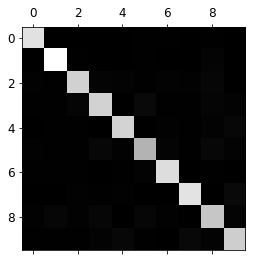

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
# First, divide each value in the confusio matrix by the number of images in the corresponding class, so you can
# compare error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

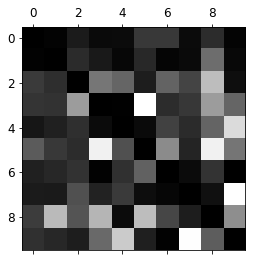

In [49]:
# Now let's fill the diagonal with zeros to keep only the errors, and let's plot the result
# Rows represent actual classes, while columns represent predicited classes
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The columns for 8 and 9 are quite brite, which tells you that many images get misclassified as 8s or 9s.

Similarly, the rows for classes 8 and 9 are also quite brite, telling you that 8s and 9s are often confused with other digits. 

Conversly, some rows are pretty dark, such as row 1: this means that most 1s are clasified correctly. 

# Multilabel Classification

In some cases you want your classifier to output multiple classes for each instance. Say for example that a classifier has been trained to recognize three faces, Alice, Mohammed and Frank; then when it is shown a picture of Alice and Frank, it should output [1,0,1] (meaning "Alice yes, Mohammed No, Frank yes"). 

Such a classification system that outputs multiple binary labels is called a multilabel classification system

In [50]:
from sklearn.neighbors import KNeighborsClassifier


# Code creates a y_mltilabel array containing two target labels for each digit image: the first indicates whether
#    or not the digit is large (7,8, or 9) and the second indicates whether or not it is odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]


# This creates a KNeighborsClassifier instance (which supports multilabel classification, but not all classifiers do)
#    and we train it using multiple targets array
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [51]:
# Now we make a prediction, and note that it outputs two labels - large (false), and odd (true)
knn_clf.predict([some_digit])

array([[False,  True]])

WARNING: the following cell may take a very long time to run

In [ ]:
# Several ways to evaluate a multilabel classifier. The following code computes the average F1 score acorss all labels
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

The previous code assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than Mohammed or Frank, you may want to give more weight to the classifier's score on pictures of Alice.

One simple option is to give each label a weight equal to its "support" (i.e., the number of instances with that target label). To do this simply set average="weighted" in the preceding code.

# Multioutput Classification

Multioutput-multiclass classification (or simply multioutput classification) is simply a generalization of multilable classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. 

Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). 

In [ ]:
# Let's start by creating the training and test sets by taking the MNIST images and adding noise to their pixel
#   intensities using NumPy's randint() function. The target images will be the original images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

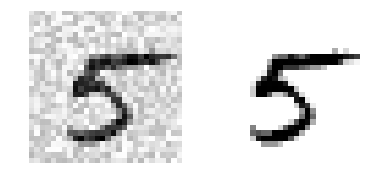

In [57]:
# Let's take a peek at an image from the test set:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

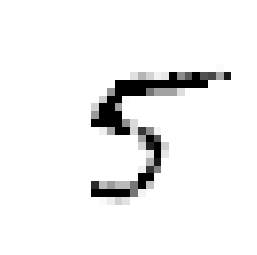

In [58]:
# Now let's train the classifier and make it clean this image:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)